In [66]:
import gym
from gym import spaces
import numpy as np
import math
import matplotlib.pyplot as plt

In [67]:
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

In [68]:
space = spaces.MultiBinary(3)
print([space.sample() for _ in range(5)])

[array([1, 0, 1], dtype=int8), array([0, 1, 1], dtype=int8), array([1, 1, 0], dtype=int8), array([0, 0, 0], dtype=int8), array([0, 1, 0], dtype=int8)]


In [71]:
class MigraineEnv(gym.Env):
    def __init__(self, num_triggers: int = 2, horizon: int = 20):
        self.num_triggers = num_triggers
        self.horizon = horizon
        self.timestep = 0
        self.observation_space = spaces.Discrete(2)  # 0: no migraine, 1: migraine
        self.action_space = spaces.Box(low=0, high=1, shape=(num_triggers,), dtype=np.float32)  # continuous actions
        self.state = self.observation_space.sample()
        self.h_j = 0.5  # equal probability for any specific migraine trigger
        self.history = np.zeros((horizon, num_triggers))  # history of actions

    def reset(self):
        self.state = self.observation_space.sample()
        self.timestep = 0
        self.history = np.zeros((self.horizon, self.num_triggers))
        return self.state

    def step(self, action: np.array):
        self.history[self.timestep] = action
        y_nat = np.random.normal(0, 1)  # Sample from N(0, 1)
        y_next = self.calculate_wellness(action, y_nat)
        self.state = 1 if y_next > 0 else 0  # Binary state based on y_next
        self.timestep += 1
        done = self.timestep >= self.horizon
        return self.state, -self.state, done, {}  # Reward is negative of the state (minimize migraines)

    def calculate_wellness(self, action, y_nat):
        # Calculate the wellness of the next state using the provided system model
        y_next = y_nat
        for j in range(self.num_triggers):
            for k in range(self.timestep + 1):
                y_next += self.h_j * self.history[self.timestep - k, j]
        return y_next

    def gradient_descent(self, learning_rate=0.01):
        # Perform gradient descent on the actions to minimize the occurrence of migraines
        gradients = np.zeros_like(self.history)
        for t in range(self.horizon):
            for j in range(self.num_triggers):
                # Calculate the gradient for action u_{j, t}
                # Assuming partial derivative of y_next with respect to u_{j, t} is h_j
                gradients[t, j] = self.h_j * (1 if self.state == 1 else -1)
            # Update the actions based on the gradients
            self.history[t] = np.clip(self.history[t] - learning_rate * gradients[t], 0, 1)
        return self.history

    def render(self, mode='human'):
        pass

In [75]:
def rollout_minimize_migraine(env, learning_rate=0.01, num_iterations=100):
    # Initialize the environment
    env.reset()
    
    # Store the intensity levels at each iteration
    intensity_over_time = np.zeros((num_iterations, env.num_triggers))
    
    # Perform the rollout for a specified number of iterations
    for iteration in range(num_iterations):
        # Reset the environment at the start of each iteration
        state = env.reset()
        
        # Perform a rollout over the time horizon
        for t in range(env.horizon):
            # Sample a random action (this could be replaced with a policy or other method)
            action = env.action_space.sample()
            
            # Take a step in the environment with the chosen action
            state, reward, done, _ = env.step(action)
            
            # If the time horizon is reached, break out of the loop
            if done:
                break
        
        # Perform gradient descent to minimize the intensity of migraine triggers
        env.gradient_descent(learning_rate=learning_rate)
        
        # Store the average intensity levels for this iteration
        intensity_over_time[iteration] = env.history.mean(axis=0)
    
    # Return the history of intensity levels over time
    return intensity_over_time

State : {0, 1} means either no migraine or yes migraine. 

Action: {0, 1} means either you are exposed or not exposed.

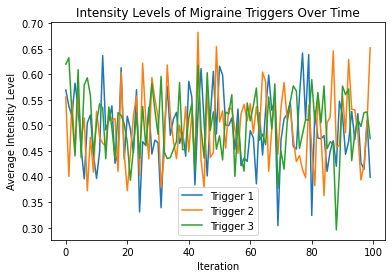

In [78]:
# Create an instance of the MigraineEnv
num_triggers = 3
horizon = 20
env = MigraineEnv(num_triggers=num_triggers, horizon=horizon)

# Perform the rollout to minimize migraine triggers
intensity_over_time = rollout_minimize_migraine(env)

# Plot the intensity levels over time
for trigger_index in range(num_triggers):
    plt.plot(intensity_over_time[:, trigger_index], label=f'Trigger {trigger_index + 1}')

plt.xlabel('Iteration')
plt.ylabel('Average Intensity Level')
plt.title('Intensity Levels of Migraine Triggers Over Time')
plt.legend()
plt.show()